# 3. Content based model

This notebook is about creating a content based recommendation model with the tmdb dataset. In contrast to collaborative filetering models where the user ratings are taken into account, contet based models are, as the name implies, based only on the conent of items. To define the conent, Natural Language Processing (NLP) tools are the most popular, whereby the user defines which texts should be used. The choice of texts again defines how similar the output recommendations are to the input item. For this project we tested different variants of texts as variables, so that the final recommendations are based e.g. only on the movie description or on the movie description + actors etc. and had a closer look on the meaningfulness of the outputs. 

In [3]:
#Import requirements
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD#, evaluate

/Users/alexandrazimmermann/neue_fische/recommender-system-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Load in the data

In [4]:
#load data
movielens_links = pd.read_csv('data/ml-latest-small/movies.csv')

In [5]:
links_small = pd.read_csv('data/ml-latest-small/links.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [6]:
tmdb = pd. read_csv('data/tmdb/movies_metadata.csv')

/Users/alexandrazimmermann/neue_fische/recommender-system-capstone/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data cleaning

In [7]:
# convert genres to list
tmdb['genres'] = tmdb['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
# drop rows with non id values
tmdb = tmdb.drop([19730, 29503, 35587])

In [9]:
#convert id column to integer
tmdb['id'] = tmdb['id'].astype('int')

In [10]:
#reduce metadata file (tmdb) to ids also found in movielens links file (links_small)
smd = tmdb[tmdb['id'].isin(links_small)]
smd.shape

(9553, 24)

In [11]:
#find duplicates
smd.overview.duplicated().sum()

39

In [12]:
# drop duplicates based on overview column
smd = smd.drop_duplicates(subset=["overview"])

In [13]:
# write NA value indices to list
smd[smd['overview'].isnull()].index.tolist()

[300]

In [14]:
#drop NA row in overview
smd = smd.drop([300])

In [15]:
# find NA values in overview column
smd.overview.isna().sum()

0

In [16]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Creation of fist model based only on overview


This is a first model where only the movie description (overview) was used as base for the recommenadtions.

In [17]:
#use NLP 
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['overview'])

In [18]:
#calculate similarity with cosine similarity measure
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [19]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


The index has to be reset due to missing numbers

In [20]:
#reset index 
smd = smd.reset_index()
#define titles series
titles = smd['title']
#define indices series
indices = pd.Series(smd.index, index=smd['title'])

In [21]:
smd.head(35)

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,5,False,NaN,60000000,"[Action, Crime, Drama, Thriller]",NaN,949,tt0113277,en,Heat,...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,6,False,NaN,58000000,"[Comedy, Romance]",NaN,11860,tt0114319,en,Sabrina,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,7,False,NaN,0,"[Action, Adventure, Drama, Family]",NaN,45325,tt0112302,en,Tom and Huck,...,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0
8,8,False,NaN,35000000,"[Action, Adventure, Thriller]",NaN,9091,tt0114576,en,Sudden Death,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
9,9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[Adventure, Action, Thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,...,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0


In [22]:
def get_recommendations(title):
    """this function takes in a movie title, sorts the sim_scores which are based on previously calculated cosine similarity and gives out a list of most similar items
    """
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [23]:
#recommendataion
get_recommendations('Toy Story')[:10]

7320               Toy Story 3
2348               Toy Story 2
5947    The 40 Year Old Virgin
837      Rebel Without a Cause
2385           Man on the Moon
6393              Factory Girl
1507                 Condorman
6316    For Your Consideration
4755          Rivers and Tides
9143      Welcome to Happiness
Name: title, dtype: object

In [24]:
# create description column from tagline and overview
smd['tagline'] = smd['tagline'].fillna('') 
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [25]:
smd.description[0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [26]:
# NLP
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [27]:
#cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
#recommendataion
get_recommendations('Toy Story')[:10]

2348               Toy Story 2
7320               Toy Story 3
5947    The 40 Year Old Virgin
2385           Man on the Moon
6393              Factory Girl
4447    What's Up, Tiger Lily?
837      Rebel Without a Cause
6316    For Your Consideration
4755          Rivers and Tides
9143      Welcome to Happiness
Name: title, dtype: object

### Additional metadata

To get more complex models lets load in more metadata

In [29]:
credits = pd.read_csv('data/tmdb/credits.csv')
keywords = pd.read_csv('data/tmdb/keywords.csv')

In [30]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
tmdb['id'] = tmdb['id'].astype('int')

In [31]:
tmdb.shape

(45463, 24)

In [32]:
# merge additional data 
tmdb = tmdb.merge(credits, on='id')
tmdb = tmdb.merge(keywords, on='id')

In [33]:
# subset with movielens data
smd = tmdb[tmdb['id'].isin(links_small)]
smd.shape

(9657, 27)

In [34]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [35]:
smd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9657 entries, 0 to 46533
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9657 non-null   object 
 1   belongs_to_collection  1879 non-null   object 
 2   budget                 9657 non-null   object 
 3   genres                 9657 non-null   object 
 4   homepage               2334 non-null   object 
 5   id                     9657 non-null   int64  
 6   imdb_id                9655 non-null   object 
 7   original_language      9657 non-null   object 
 8   original_title         9657 non-null   object 
 9   overview               9638 non-null   object 
 10  popularity             9657 non-null   object 
 11  poster_path            9654 non-null   object 
 12  production_companies   9657 non-null   object 
 13  production_countries   9657 non-null   object 
 14  release_date           9655 non-null   object 
 15  rev

In [36]:
#check type of column
type(smd.loc[0, "cast"])

str

In [37]:
#apply literal_eval from Abstract Syntax Trees (ast) to convert str into a list of dictionaries
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)

/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/3906202070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(literal_eval)
/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/3906202070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['crew'] = smd['crew'].apply(literal_eval)
/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/3906202070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [38]:
smd.cast[0]

[{'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'},
 {'cast_id': 15,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe4284c3a36847f8024f99',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1,
  'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
 {'cast_id': 16,
  'character': 'Mr. Potato Head (voice)',
  'credit_id': '52fe4284c3a36847f8024f9d',
  'gender': 2,
  'id': 7167,
  'name': 'Don Rickles',
  'order': 2,
  'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 {'cast_id': 17,
  'character': 'Slinky Dog (voice)',
  'credit_id': '52fe4284c3a36847f8024fa1',
  'gender': 2,
  'id': 12899,
  'name': 'Jim Varney',
  'order': 3,
  'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
 {'cast_id': 18,
  'character': 'Rex (voice)',
  'credit_id': '52fe4284c3a36847f8024fa5',
  'gender': 2,
  'id': 12900,
 

In [39]:
smd.crew[0]

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f55',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Screenplay',
  'name': 'Andrew Stanton',
  'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f5b',
  'department': 'Writing',
  'gender': 2,
  'id': 12892,
  'job': 'Screenplay',
  'name': 'Joel Cohen',
  'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f61',
  'department': 'Writing',
  'gender': 0,
  'id': 12893,
  'job': 'Screenplay',
  'name': 'Alec Sokolow',
  'profile_path': '/v79vlRYi94BZUQnkkyzn

In [40]:
#print keywords column
smd.keywords[0]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [41]:
#reset index 
smd = smd.reset_index()

Since the cast, crew and keywords columns contain list of dictionaries the relevant content needs to be extracted for further usage.

In [42]:
# convert dictionary content to lists

names = [d['name'] for d in smd.cast[0]]
names

['Tom Hanks',
 'Tim Allen',
 'Don Rickles',
 'Jim Varney',
 'Wallace Shawn',
 'John Ratzenberger',
 'Annie Potts',
 'John Morris',
 'Erik von Detten',
 'Laurie Metcalf',
 'R. Lee Ermey',
 'Sarah Freeman',
 'Penn Jillette']

In [43]:
#inspect first element
smd.crew[0][0]

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

In [44]:
#create function to get list of lists
def get_lists(key, column):
    """this function takes in a keyword (key) which is to be extracted and a column containing this key. The output is a column containg the respective values a lists
    """
    x = []

    for i in range(smd.shape[0]):
        values = [d[f"{key}"] for d in smd[f"{column}"][i]]
        x.append(values)
    return x

In [45]:
# add new columns to smd data frame
smd["crew_jobs"] = pd.Series(get_lists("job", "crew"))
smd["actors"] = pd.Series(get_lists("name", "cast"))
smd["keywords"] = pd.Series(get_lists("name", "keywords"))

In [117]:
smd.crew_jobs

0       [Director, Screenplay, Screenplay, Screenplay,...
1       [Executive Producer, Screenplay, Original Musi...
2         [Director, Characters, Writer, Sound Recordist]
3       [Director, Screenplay, Producer, Producer, Pro...
4       [Original Music Composer, Director of Photogra...
                              ...                        
9652    [Sound Designer, Director, Novel, Producer, Pr...
9653    [Director, Director, Director, Director, Write...
9654                                   [Director, Writer]
9655                                                   []
9656    [Producer, Executive Producer, Executive Produ...
Name: crew_jobs, Length: 9657, dtype: object

In [46]:
# check
smd.columns

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'crew_jobs',
       'actors'],
      dtype='object')

### Model with new features

In [47]:
#convert list to string and create column with strings 
smd.actors_str = smd.actors.apply(" ".join)

/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/3472090846.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smd.actors_str = smd.actors.apply(" ".join)


In [48]:
#check
smd.actors_str

0       Tom Hanks Tim Allen Don Rickles Jim Varney Wal...
1       Robin Williams Jonathan Hyde Kirsten Dunst Bra...
2       Walter Matthau Jack Lemmon Ann-Margret Sophia ...
3       Whitney Houston Angela Bassett Loretta Devine ...
4       Steve Martin Diane Keaton Martin Short Kimberl...
                              ...                        
9652    Michel Piccoli Miou-Miou Béatrice Romand Franc...
9653                                     Brunhilde Pomsel
9654    Julian Radlmaier Deragh Campbell Beniamin Fort...
9655                                    Helmut Qualtinger
9656    Grey Griffin Tara Strong Anais Fairweather Tea...
Name: actors, Length: 9657, dtype: object

In [49]:
# create description column 

smd['description'] = smd['overview'] + smd.actors_str
smd['description'] = smd['description'].fillna('')

# NLP
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

#calculate similarity with cosine similarity measure
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#recommendataion
get_recommendations('Toy Story')[:10]

2365                        The Green Mile
7402                       Never Let Me Go
853                                The Fog
1383                            Henry Fool
4087                    The Quiet American
1694    The Fiendish Plot of Dr. Fu Manchu
1215                        Kiss the Girls
2082                               Head On
955                                      M
8350                                  Noah
Name: title, dtype: object

In case of Toy story, which is an animation film, recommendation based on actors seems not to be an good idea. Most of the actors do normally play in other genres.

As can be seen above the job of the crew member alone is not very useful. We need the names with respect to the jobs.

In [50]:
#create function to get name by job 
def get_names(job):
    """function that gives out the name of a person defined by the persons job in the film crew"""
    x = []

    for i in range(smd.shape[0]):
        values = [d["name"] for d in smd["crew"][i] if d["job"] == f"{job}"]
        x.append(values)
    return x

In [51]:
def jobs_to_column_and_string(job):
    """function to create two new columns in smd dataframe, one for the names by jobs and one where the lists of names are converted to strings"""

    smd[job] = pd.Series(get_names(job))
    smd[f"{job}_str"]= smd[job].apply(" ".join)

In [52]:
jobs_to_column_and_string("Director")
jobs_to_column_and_string("Writer")
jobs_to_column_and_string("Executive Producer")

But how to get the most common people per job? It might be useful for the recommender system to use only the popular ones. <br>
I found this very useful website on how to deal with lists in pandas data frame : https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [53]:
#this function is from the notebook mentioned above. It coverts the series data into an 1D array
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [54]:
#extract most common actors
to_1D(smd["actors"]).value_counts()

Samuel L. Jackson    92
Bruce Willis         71
Robert De Niro       68
John Goodman         67
Matt Damon           64
                     ..
Ho Ban Le             1
Vladimír Hrbek        1
Jirí Mojzís           1
Marta Andresová       1
Romi Dames            1
Length: 86598, dtype: int64

In [55]:
#extract most common Directors
to_1D(smd["Director"]).value_counts()

Woody Allen          47
Alfred Hitchcock     37
Clint Eastwood       31
Steven Spielberg     31
Martin Scorsese      30
                     ..
Youssef Chahine       1
Amos Gitai            1
Idrissa Ouedraogo     1
Janet Greek           1
Todd Grimes           1
Length: 4380, dtype: int64

In [56]:
#extract most common Writer
to_1D(smd["Writer"]).value_counts()

Woody Allen         13
Werner Herzog       10
Asif Kapadia         9
Bruno Dumont         8
Andy Hedden          8
                    ..
Paolo Taviani        1
Vittorio Taviani     1
Trevor Farrant       1
Gérard Jugnot        1
Julian Radlmaier     1
Length: 3803, dtype: int64

In [57]:
#extract most common keywords
to_1D(smd["keywords"]).value_counts()

independent film        613
woman director          573
murder                  398
based on novel          336
duringcreditsstinger    330
                       ... 
holiday inn               1
eminem                    1
cannes                    1
man punches woman         1
legal system              1
Length: 13195, dtype: int64

To get better recommendations it might be helpful to include a stemmer for NLP. E. g. the words holidays and holiday would have the same stem and would euqually be recognized in the movie descriptions or keywors.

In [58]:
#define stemmer
stemmer = SnowballStemmer('english')

In [59]:
#checkb
stemmer.stem("holidays")

'holiday'

In [60]:
#apply stemmer to pd.Series
smd['stemmed_keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word


In [61]:
smd.stemmed_keywords

0       [jealousi, toy, boy, friendship, friend, rival...
1       [board gam, disappear, based on children's boo...
2        [fish, best friend, duringcreditssting, old men]
3       [based on novel, interracial relationship, sin...
4       [babi, midlife crisi, confid, age, daughter, m...
                              ...                        
9652                                             [absurd]
9653                                                   []
9654                                                   []
9655                                                   []
9656                                    [superhero, lego]
Name: stemmed_keywords, Length: 9657, dtype: object

### Model with overview, actors and keywords

What if Keywords are added to the model with overview and actors? Do the keywords offset the actors?

In [62]:
#show columns
smd.columns

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'crew_jobs',
       'actors', 'description', 'Director', 'Director_str', 'Writer',
       'Writer_str', 'Executive Producer', 'Executive Producer_str',
       'stemmed_keywords'],
      dtype='object')

In [63]:
#convert list to string and create column with strings 
smd.stemmed_keywords_str = smd.stemmed_keywords.apply(" ".join)

/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/1602183610.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smd.stemmed_keywords_str = smd.stemmed_keywords.apply(" ".join)


In [64]:
# inspect first element
smd.stemmed_keywords_str[0]

'jealousi toy boy friendship friend rivalri boy next door new toy toy comes to lif'

Lets compare the recommendation with the model with overview and actors. The results from that model were:
 
                            The Green Mile
7402                       Never Let Me Go
853                                The Fog
1383                            Henry Fool
4087                    The Quiet American
1694    The Fiendish Plot of Dr. Fu Manchu
1215                        Kiss the Girls
2082                               Head On
955                                      M
8350                                  Noah

As can be seen, there is huge overlap between the models with and without keywords. 

Let's choose another film

In [66]:
get_recommendations("Moon")[:10]

6747                            St. Trinian's
4702                 The Secret of My Success
6039                                    CRAZY
6907             Blackadder's Christmas Carol
3087                           Sweet November
6380    Wake Up, Ron Burgundy: The Lost Movie
7629           My Afternoons with Margueritte
7567                              Bridesmaids
6386                                   Breach
7482                     I Spit on Your Grave
Name: title, dtype: object

As can be seen above the recommendations are not as specific, as we would have expected them. This might be due to the actors which make the recommendations more diverse. To check this let's make a recommandation based on description and keywords.

In [67]:
#data frame for model with keywords, overview and actors
smd['soup'] = smd.stemmed_keywords_str + smd.overview 

# NLP
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['soup'].values.astype('U')) #converts to type unicode

#calculate similarity with cosine similarity measure
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#recommendataion
get_recommendations("Moon")[:10]

6747                            St. Trinian's
6907             Blackadder's Christmas Carol
4702                 The Secret of My Success
6380    Wake Up, Ron Burgundy: The Lost Movie
6726                         Sex and the City
607                                     Heavy
7567                              Bridesmaids
3087                           Sweet November
5446                      Au Hasard Balthazar
6347               Curse of the Golden Flower
Name: title, dtype: object

We would have expected more space movies.

In [ ]:
#data frame for model with keywords, overview and actors
smd['soup'] = smd.overview

# NLP
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['soup'].values.astype('U')) #converts to type unicode

#calculate similarity with cosine similarity measure
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#recommendataion
get_recommendations("Toy Story")[:10]

7402                Never Let Me Go
2365                 The Green Mile
6018                      Manderlay
853                         The Fog
2402                       Papillon
6465    I'm a Cyborg, But That's OK
1523                    BASEketball
6387           Daddy's Little Girls
9256                   Jason Bourne
9257                The Maid's Room
Name: title, dtype: object

### New vectorizer

Let's try another vectorizer 

In [ ]:
#use CountVectorizer for NLP
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'].values.astype('U'))
#calculate similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
#recommendataion
get_recommendations("Toy Story")[:10]

2365               Toy Story 2
7402               Toy Story 3
6018    The 40 Year Old Virgin
6465              Factory Girl
2402           Man on the Moon
4808          Rivers and Tides
853      Rebel Without a Cause
1523                 Condorman
427                     Malice
394          For Love or Money
Name: title, dtype: object

The countvectorizer seems to do give more reasonable recommendations.

### New test models

### Countvectorizer models

#### model with description

In [68]:
#data frame for model with keywords, overview and actors
smd['text'] = smd.overview

#use CountVectorizer for NLP
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['text'].values.astype('U'))
#calculate similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# 
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

#recommendataion
get_recommendations("Toy Story")[:10]

2365               Toy Story 2
7402               Toy Story 3
6018    The 40 Year Old Virgin
6465              Factory Girl
2402           Man on the Moon
4808          Rivers and Tides
853      Rebel Without a Cause
1523                 Condorman
427                     Malice
394          For Love or Money
Name: title, dtype: object

In [69]:
get_recommendations("Moon")[:10]

534     All Dogs Go to Heaven 2
936             A Grand Day Out
3671                   I Am Sam
7892    Space Battleship Yamato
505                       Ghost
1819         Cocoon: The Return
142                     Hackers
1818                     Cocoon
7841                  Apollo 18
823                    Swingers
Name: title, dtype: object

In [92]:
#recommendataion
get_recommendations("Batman Begins")[:10]

6752                            The Dark Knight
509                                      Batman
7427                 Batman: Under the Red Hood
7811                      The Dark Knight Rises
1185                             Batman & Robin
1072                             Batman Returns
8996         Batman v Superman: Dawn of Justice
8074    Batman: The Dark Knight Returns, Part 1
8275            Batman: Mystery of the Batwoman
7776                           Batman: Year One
Name: title, dtype: object

This model seems to predict reasonable movies e.g. other space movies

#### model with descriptions + keywords 

In [78]:
#convert list to string and create column with strings 
smd.keywords_str = smd.keywords.apply(" ".join)

In [90]:
#data frame for model with keywords, overview and actors
smd['text'] = smd.overview + smd.keywords_str

#use CountVectorizer for NLP
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['text'].values.astype('U'))
#calculate similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

#recommendataion
get_recommendations("Toy Story")[:10]

2365                   Toy Story 2
7402                   Toy Story 3
1412                Small Soldiers
53      The Indian in the Cupboard
6018        The 40 Year Old Virgin
1479                Child's Play 3
1478                Child's Play 2
1477                  Child's Play
5124                         Dolls
1685                          Toys
Name: title, dtype: object

In [81]:
get_recommendations("Moon")[:10]

712            2001: A Space Odyssey
936                  A Grand Day Out
7841                       Apollo 18
3148                        The Dish
3953    The Adventures of Pluto Nash
5914              A Trip to the Moon
8569                        Automata
8697                   Space Buddies
5995                         Stealth
1272               Starship Troopers
Name: title, dtype: object

In [91]:
#recommendataion
get_recommendations("Batman Begins")[:10]

6752                            The Dark Knight
509                                      Batman
7427                 Batman: Under the Red Hood
7811                      The Dark Knight Rises
1185                             Batman & Robin
1072                             Batman Returns
8996         Batman v Superman: Dawn of Justice
8074    Batman: The Dark Knight Returns, Part 1
8275            Batman: Mystery of the Batwoman
7776                           Batman: Year One
Name: title, dtype: object

Both recommendations seem to give more accurate movie recommendations

#### model with description + keywords + actors

In [85]:
#convert list to string and create column with strings 
smd.actors_str = smd.actors.apply(" ".join)

/var/folders/0f/5nqwl_8j7n1dmfgmn2m0tztw0000gn/T/ipykernel_17254/3472090846.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smd.actors_str = smd.actors.apply(" ".join)


In [86]:
#data frame for model with keywords, overview and actors
smd['text'] = smd.overview + smd.keywords_str + smd.actors_str

#use CountVectorizer for NLP
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['text'].values.astype('U'))
#calculate similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

#recommendataion
get_recommendations("Toy Story")[:10]

2365          Toy Story 2
7402          Toy Story 3
1412       Small Soldiers
5124                Dolls
1477         Child's Play
2114                  Big
1685                 Toys
1837    The Thin Red Line
1263              Stripes
2536                  JFK
Name: title, dtype: object

In [87]:
#recommendataion
get_recommendations("Moon")[:10]

936                  A Grand Day Out
7841                       Apollo 18
5914              A Trip to the Moon
3953    The Adventures of Pluto Nash
3148                        The Dish
712            2001: A Space Odyssey
7530                    TRON: Legacy
6730                        Semi-Pro
3875                  Silent Running
7071            Terminator Salvation
Name: title, dtype: object

In [88]:
#recommendataion
get_recommendations("Batman Begins")[:10]

7811           The Dark Knight Rises
6752                 The Dark Knight
1997                        Superman
1170               The Fifth Element
509                           Batman
6359                    The Departed
4726                           Hoffa
7427      Batman: Under the Red Hood
3123    The Greatest Story Ever Told
6572                        Stardust
Name: title, dtype: object

This model brings more diversity into the recommendations

#### model with descrition + keywords + top actors

#### data preparation

Not every actor might be important for a recommendation. So let's focus on the popular actors. 

In [109]:
#extract most common actors
pop_actors = pd.Series(to_1D(smd["actors"]).value_counts())
pop_actors[:3]

Samuel L. Jackson    92
Bruce Willis         71
Robert De Niro       68
dtype: int64

Let's see how the actors are distributed

/Users/alexandrazimmermann/neue_fische/recommender-system-capstone/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

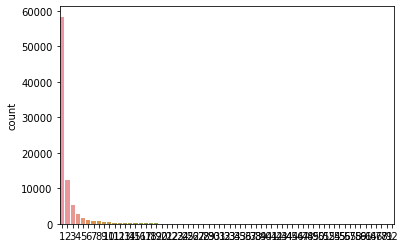

In [98]:
sns.countplot(pop_actors)

As can be seen above most of the actors do only play in one Movie. 

In [110]:
pop_actors[:20]

Samuel L. Jackson     92
Bruce Willis          71
Robert De Niro        68
John Goodman          67
Matt Damon            64
Steve Buscemi         61
Morgan Freeman        61
Robin Williams        59
Frank Welker          59
Jackie Chan           58
Richard Jenkins       57
Liam Neeson           57
Christopher Walken    57
Michael Caine         56
Stanley Tucci         56
Johnny Depp           56
Bess Flowers          55
Donald Sutherland     55
Nicolas Cage          54
Willem Dafoe          54
dtype: int64

#### model

#### model with description + keywords + actors + director

In [118]:
#data frame for model with keywords, overview and actors
smd['text'] = smd.overview + smd.keywords_str + smd.actors_str +smd.Director_str
#use CountVectorizer for NLP
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['text'].values.astype('U'))
#calculate similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

#recommendataion
get_recommendations("Toy Story")[:10]

2365               Toy Story 2
7402               Toy Story 3
1412            Small Soldiers
5124                     Dolls
2114                       Big
1685                      Toys
1477              Child's Play
4500    What's Up, Tiger Lily?
1837         The Thin Red Line
4138           Treasure Planet
Name: title, dtype: object

In [120]:
type(cosine_sim)

numpy.ndarray

In [112]:
#recommendataion
get_recommendations("Moon")[:10]

936                  A Grand Day Out
7841                       Apollo 18
5914              A Trip to the Moon
3953    The Adventures of Pluto Nash
3148                        The Dish
712            2001: A Space Odyssey
7530                    TRON: Legacy
6730                        Semi-Pro
3875                  Silent Running
7071            Terminator Salvation
Name: title, dtype: object

In [113]:
#recommendataion
get_recommendations("Batman Begins")[:10]

7811           The Dark Knight Rises
6752                 The Dark Knight
1997                        Superman
1170               The Fifth Element
509                           Batman
6359                    The Departed
4726                           Hoffa
7427      Batman: Under the Red Hood
3123    The Greatest Story Ever Told
6817                       Get Smart
Name: title, dtype: object

In [114]:
#recommendataion
get_recommendations("Interstellar")[:10]

4137                  Solaris
1409               Armageddon
3875           Silent Running
7811    The Dark Knight Rises
3542                SpaceCamp
943           The Right Stuff
5270             Dear Frankie
1730                     2010
6838      Stargate: Continuum
2296               Spaceballs
Name: title, dtype: object

This model seems also to give reasonable recommendations